# IQ modulation for Chirp

http://zone.ni.com/reference/en-XX/help/372058T-01/nirfsa/iq_modulation/

In [72]:
%matplotlib inline

from numpy import zeros, append, linspace, sin, cos, exp, pi, int16, abs, real, imag, random, sqrt, log10
from scipy.io.wavfile import write
from scipy.signal import spectrogram, butter, buttord, lfilter
from scipy.fftpack import fft, ifft, fftfreq, fftshift
import matplotlib.pyplot as plt
import peakutils
import pandas
from IPython.display import display, Audio

In [114]:
#SAMPLING_RATE = 8000  # Hz
SAMPLING_RATE = 100000  # Hz
SAMPLES = 2048
TIME_FRAME = SAMPLES/SAMPLING_RATE # Time frame in sec
AMPLITUDE = 20000 # 16bit PCM max amplitude

# Chirp sweep range in Hz
F0 = -1000
F1 = 1000

CARRIER=17000

WAVE_FILE="./ChirpTone.wav"

## Chirp tone synthesis

In [115]:
# Complex version of chirp tone generator
def chirp(f0=F0, f1=F1, amp=AMPLITUDE, updown="up", T=TIME_FRAME, phase=-pi/2.0, rot=1.0):
    t = linspace(0, T, int(T * SAMPLING_RATE))
    k = float(f1 - f0)/float(T)
    if (updown == "up"):
        f = f0 + k * t / 2.0
    elif (updown == "down"):
        f = f1 - k * t / 2.0
    arg = (2.0 * pi * f * t) * rot + phase
    return exp(1j * arg) * amp

# Real version of chirp tone generator
def chirp_cos(f0=F0, f1=F1, amp=AMPLITUDE, updown="up", T=TIME_FRAME, phase=-pi/2.0, rot=1.0):
    t = linspace(0, T, int(T * SAMPLING_RATE))
    k = float(f1 - f0)/float(T)
    if (updown == "up"):
        f = f0 + k * t / 2.0
    elif (updown == "down"):
        f = f1 - k * t / 2.0
    arg = (2.0 * pi * f * t) * rot + phase
    return cos(arg) * amp

def chirp_sin(f0=F0, f1=F1, amp=AMPLITUDE, updown="up", T=TIME_FRAME, phase=-pi/2.0, rot=1.0):
    t = linspace(0, T, int(T * SAMPLING_RATE))
    k = float(f1 - f0)/float(T)
    if (updown == "up"):
        f = f0 + k * t / 2.0
    elif (updown == "down"):
        f = f1 - k * t / 2.0
    arg = (2.0 * pi * f * t) * rot + phase
    return sin(arg) * amp

# Add time delay to chirp signal
def add_delay(chirp, delay_rate=0.0):
    l = len(chirp)
    la = int(l * delay_rate)
    a = zeros(la)
    b = zeros(2 * l - (l + la))
    return append(append(a, chirp), b)

# White noise generator
def white_noise(amp=AMPLITUDE, T=TIME_FRAME):
    a = random.random(int(T * SAMPLING_RATE)) * 2 * amp - amp
    # b = random.random(int(length * SAMPLING_RATE)) * 2 * amp - amp
    #return a + 1j * b
    return a

# Constant noise generator
def constant_noise(f=0, amp=AMPLITUDE, T=TIME_FRAME, phase=-pi/2.0, rot=1.0):
    t = linspace(0, length, int(T * SAMPLING_RATE))
    arg = (2 * pi * f * t) * rot + phase
    return cos(arg) * amp

## FFT/IFFT functions

In [116]:
# Plot FFT frequency domain
def plot_fft(wave, thres=0.95, logscale=False):
    plt.figure(figsize=(8, 4), dpi=80)
    y = fftshift(fft(wave))
    freq = fftshift(fftfreq(len(y), 1/SAMPLING_RATE))

    a = abs(y)
    if logscale:
        plt.plot(freq, 10 * log10(a))
        plt.ylabel("Magnitude(dB)")
    else:
        plt.plot(freq, a)
        plt.ylabel("Magnitude")
    plt.xlabel("Frequency(Hz)")
    plt.title("Frequency domain")

    freq = fftshift(fftfreq(len(y), 1/SAMPLING_RATE))
    print("Frequencies at peaks: {} Hz".format(freq[peakutils.indexes(a, thres=thres)]))

# Plot spectrogram
def plot_spectrogram(wave, nperseg, band):
    plt.figure(figsize=(8, 3), dpi=80)
    f, t, Sxx = spectrogram(real(wave), nperseg=nperseg, fs=SAMPLING_RATE)
    plt.pcolormesh(t, f[:band], Sxx[:band])
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title("Spectrogram")

# Plot wave
def plot_wave(wave, real_only=True, logscale=False):
    t = linspace(0, len(wave)/SAMPLING_RATE, len(wave))
    plt.figure(figsize=(8, 4), dpi=80)

    re = real(wave)
    im = imag(wave)
    if logscale:
        re = 10 * log10(re)
        im = 10 * log10(im)
        plt.ylabel('Amplitude(dB)')
    else:
        plt.ylabel('Amplitude')

    if real_only:
        plt.plot(t, re)
    else:
        plt.plot(t, re)
        plt.plot(t, im)

    plt.xlabel('Time [sec]')
    plt.title("Time domain")

In [117]:
def carrier_IQ(iq, f=CARRIER):
    t = linspace(0, TIME_FRAME, int(TIME_FRAME * SAMPLING_RATE))
    if iq == 'i':
        return cos(2 * pi * f * t)
    else:
        return sin(2 * pi * f * t)
    
def chirp_IQ(iq):
    t = linspace(0, TIME_FRAME, int(TIME_FRAME * SAMPLING_RATE))
    if iq == 'i':
        return chirp_cos()
    else:
        return chirp_sin() 
    
def lpf(f, cutoff):
    WP = float(cutoff)/float(SAMPLING_RATE/2)
    WS = 1.5 * WP
    N, Wn = buttord(wp=WP, ws=WS, gpass=2, gstop=30, analog=0)
    b, a = butter(N, Wn, btype='low', analog=0, output='ba')
    g = lfilter(b, a, f)
    return g

## Carrier

In [118]:
Ci = carrier_IQ(iq='i')
Cq = carrier_IQ(iq='q')

## Baseband signal

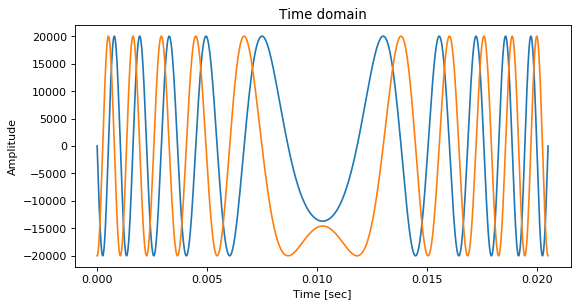

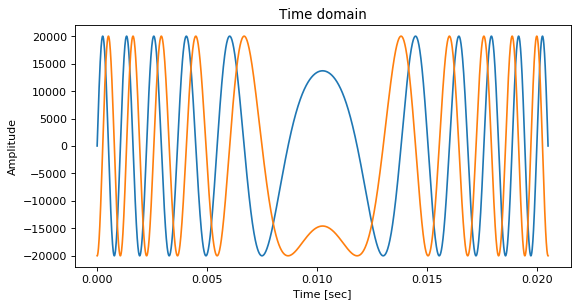

In [119]:
plot_wave(chirp(), real_only=False)
plot_wave(chirp(updown="down"), real_only=False)

In [120]:
Bi = chirp_IQ(iq='i')
Bq = chirp_IQ(iq='q')

## Transmitted tone

Frequencies at peaks: [-17724.609375 -16259.765625  16259.765625  17724.609375] Hz


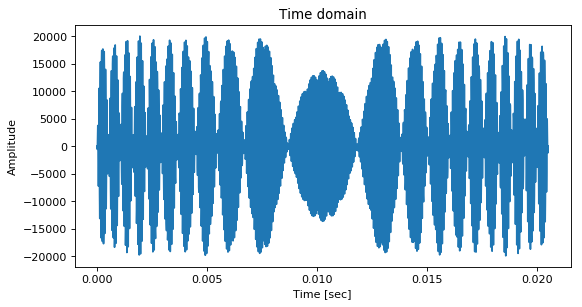

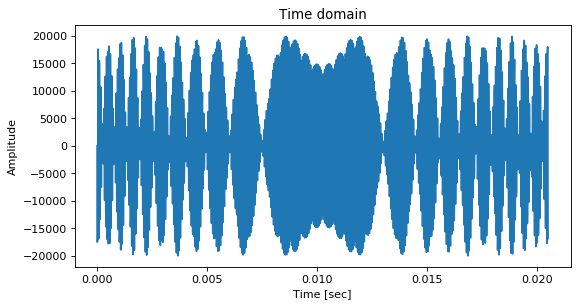

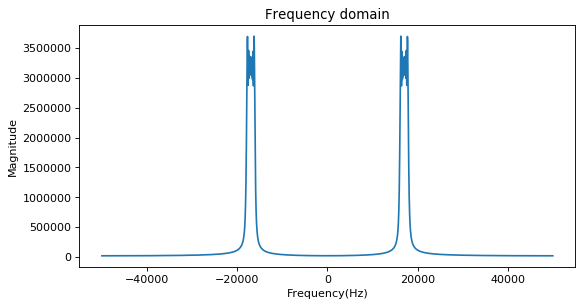

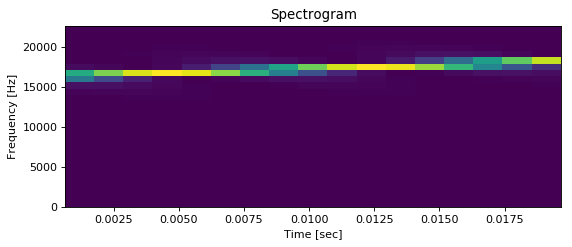

In [121]:
plot_wave(Bi*Ci)
plot_wave(Bq*Cq)
W = Bi*Ci - Bq*Cq
plot_fft(W)
plot_spectrogram(W, nperseg=128, band=30)

## Demodulation

Frequencies at peaks: [-732.421875  732.421875] Hz
Frequencies at peaks: [-537.109375 -439.453125    0.        439.453125  537.109375] Hz


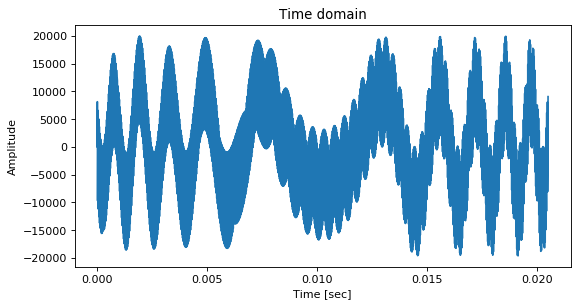

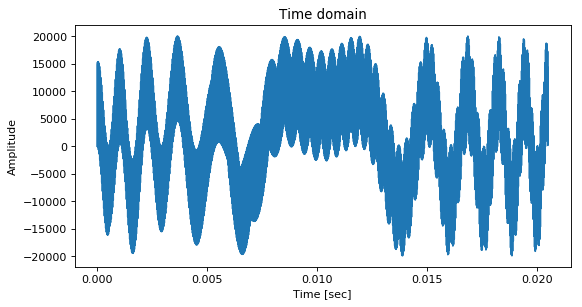

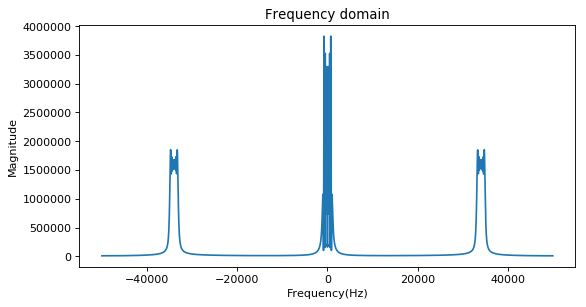

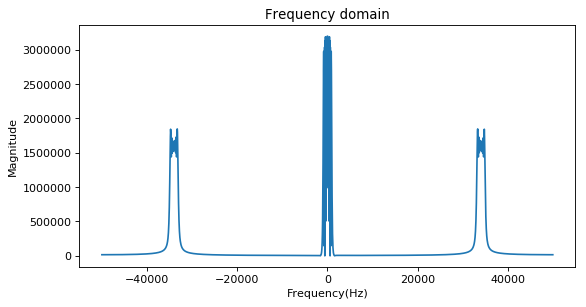

In [122]:
Ri = W*Ci
Rq = W*Cq
plot_wave(Ri)
plot_wave(Rq)
plot_fft(Ri)
plot_fft(Rq)

Frequencies at peaks: [-732.421875  732.421875] Hz


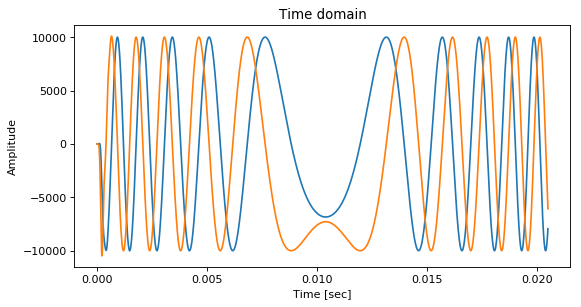

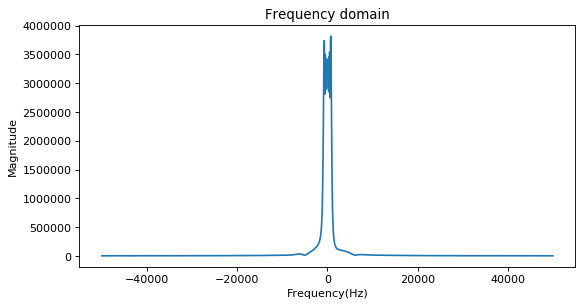

In [131]:
# LPF
R = lpf(Ri - 1j*Rq, (F1-F0) * 3 )
plot_wave(R, real_only=False)
plot_fft(R)

Frequencies at peaks: [0.] Hz
Frequencies at peaks: [0.] Hz


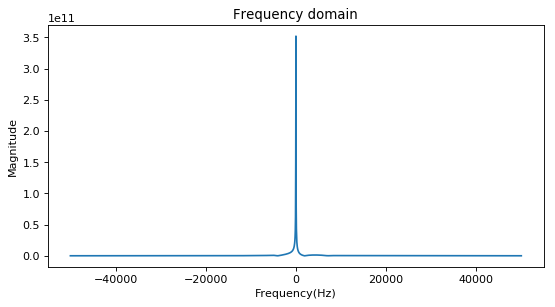

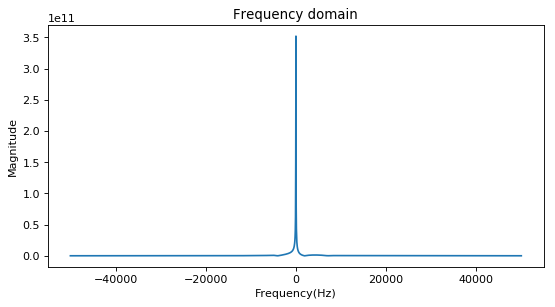

In [124]:
plot_fft(R*chirp().conjugate(), logscale=False)
plot_fft(R*chirp(updown="down"), logscale=False)